In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data')

In [11]:
# ::-1로 순서 바꾸는 방법
a = np.array([[1,2,3],
             [4.,5,6]])
# 행자리에 ::-1로 하면 큰행이 첫번째행으로 올라옴!
a[::-1]
# 열자리에 ::-1로 하면 행은 유지하되 열의 요소들이 내림차순으로 정렬됨!
a[:, ::-1]

array([[3., 2., 1.],
       [6., 5., 4.]])

In [60]:
tf.reset_default_graph()
tf.set_random_seed(123)

def MinMaxScaler(data):
    # 분자
    numerator = data - np.min(data, axis=0)
    # 분모
    denominator = np.max(data, axis=0) - np.min(data, axis=0)
    # 0으로 나누어지는거 방지하기 위해 epsilon 더해서 divide
    return numerator / (denominator + 1e-7)

## Train Parameter
# 1개 window당 길이이며 RNN Cell개수(n_steps에 해당)
n_steps = 7
# feature 개수
n_inputs = 5
n_neurons = 10
n_outputs = 1
learning_rate = 0.01
iterations = 50

xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
# 최근->과거 데이터 순으로 되어 있어 이를 역순으로 바꾸기
# 행에 ::-1 취해서 행을 역순으로 바꾸기
xy = xy[::-1]
# Scaling
xy = MinMaxScaler(xy)
# y값을 포함한 시계열 데이터를 입력 데이터로 넣기
x = xy

y = xy[:, [-1]]

In [61]:
dataX = []
dataY = []

### 1칸 뒤의 값을 예측하기 위해 Sliding Window만들기
# 1칸씩 window하기 떄문에 [ window 총 개수 = y개수 - window길이(=RNN Cell개수=n_steps) + 1 ] -> range는 0부터 시작!
for i in range(len(y) - n_steps):
    _x = x[i: i+n_steps]
    # _x값에 해당하는 정답 label
    _y = y[i+n_steps]
    dataX.append(_x)
    dataY.append(_y)

Step: 0, RMSE: 10.0186
Step: 1, RMSE: 1.5815
Step: 2, RMSE: 5.9982
Step: 3, RMSE: 4.8853
Step: 4, RMSE: 2.0389
Step: 5, RMSE: 1.4416
Step: 6, RMSE: 2.5029
Step: 7, RMSE: 3.2821
Step: 8, RMSE: 3.0157
Step: 9, RMSE: 2.1515
Step: 10, RMSE: 1.4630
Step: 11, RMSE: 1.4046
Step: 12, RMSE: 1.8330
Step: 13, RMSE: 2.2058
Step: 14, RMSE: 2.1413
Step: 15, RMSE: 1.7325
Step: 16, RMSE: 1.3396
Step: 17, RMSE: 1.2232
Step: 18, RMSE: 1.3689
Step: 19, RMSE: 1.5682
Step: 20, RMSE: 1.6222
Step: 21, RMSE: 1.4861
Step: 22, RMSE: 1.2699
Step: 23, RMSE: 1.1306
Step: 24, RMSE: 1.1463
Step: 25, RMSE: 1.2598
Step: 26, RMSE: 1.3393
Step: 27, RMSE: 1.3032
Step: 28, RMSE: 1.1860
Step: 29, RMSE: 1.0869
Step: 30, RMSE: 1.0714
Step: 31, RMSE: 1.1216
Step: 32, RMSE: 1.1680
Step: 33, RMSE: 1.1580
Step: 34, RMSE: 1.0967
Step: 35, RMSE: 1.0329
Step: 36, RMSE: 1.0109
Step: 37, RMSE: 1.0321
Step: 38, RMSE: 1.0593
Step: 39, RMSE: 1.0564
Step: 40, RMSE: 1.0218
Step: 41, RMSE: 0.9847
Step: 42, RMSE: 0.9719
Step: 43, RMSE: 0.98

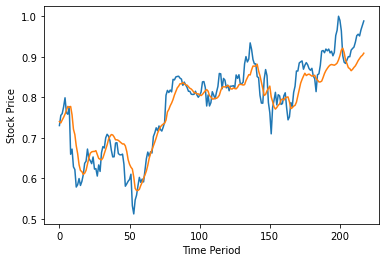

In [62]:
# split the train, test data
train_size = int(len(dataY) *0.7)
test_size = len(dataY) - train_size

trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

# RNN에 맞는 입력 데이터 shape 설정
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
Y = tf.placeholder(tf.float32, shape=[None, n_outputs])

# make LSTM model
cell = tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.tanh)

# LSTM 연결후 결과값 출력
lstm_outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32)

# size가 1인 최종결과값(1칸 뒤의 값)을 예측하기 위해 FC layer에 넣어서 output size만큼의 shape으로 출력
# 
Y_pred = tf.contrib.layers.fully_connected(lstm_outputs[:, -1], n_outputs, activation_fn=None) #Regression이라 활성함수 None

# Cost function은 Regression이기 때문에 Squared of error로 설정 - reduce_mean해서 MSE로 해도 상관없음
cost = tf.reduce_sum(tf.square(Y_pred - Y))

# Optimizer
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# RMSE값 계산하기
targets = tf.placeholder(tf.float32, shape=[None, n_outputs])
predictions = tf.placeholder(tf.float32, shape=[None, n_outputs])
rmse = tf.sqrt(tf.reduce_mean(tf.square(predictions - targets)))

### Run Tensors ###
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(iterations):
        _, y_pred, cost_val = sess.run([train, Y_pred, cost],
                              feed_dict={X: trainX,
                                        Y: trainY})
        print(f"Step: {i}, RMSE: {cost_val :.4f}")
    print(y_pred.shape)
    #print(y_pred)
    print("#"*20, "Learning Finished", "#"*20)
    # Test 데이터로 평가
    y_test_pred = sess.run(Y_pred, feed_dict={X: testX})
    #print(y_test_pred.shape)
    #print(y_test_pred)
    
    rmse_val = sess.run(rmse, feed_dict={targets: testY,
                                        predictions: y_test_pred})
    print(f"Test의 RMSE: {rmse_val :.4f}")
    
    plt.plot(testY)
    plt.plot(y_test_pred)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
    